<a href="https://colab.research.google.com/github/modichirag/sbi_tutorial/blob/main/SBI_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install emcee


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.3 MB/s eta 0:00:00


In [ ]:
!pip install sbi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=c431bfefabb2f7afca5ac28482aad8d43c13c01c033ab889b819b7ccec5facca
  Stored in directory: /root/.cache/pip/wheels/ca/8f/ac/c324eb57b461632081812c33b13161878290d0e6fbb8f5a7e2
Successfully built nflows


In [ ]:
# Define simulator

In [ ]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer
from sbi import analysis

In [ ]:
prior = utils.BoxUniform(
    low=torch.tensor([-5., -5.]),
    high=torch.tensor([5., 5.])
)


In [ ]:
def simulator(mu):
    # Generate samples from N(mu, sigma=0.5)

    return mu + 0.5 * torch.randn_like(mu)

In [ ]:
num_sim = 1000
method = 'SNPE' #SNPE or SNLE or SNRE
posterior = infer(
    simulator,
    prior,
    # See glossary for explanation of methods.
    #    SNRE newer than SNLE newer than SNPE.
    method=method,
    num_workers=-1,
    num_simulations=num_sim)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 64 epochs.

In [ ]:
n_observations = 5
observation = torch.tensor([3., -1.5])[None] + 0.5*torch.randn(n_observations, 2)

In [ ]:
samples = posterior.sample((200,), x=observation[1])

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

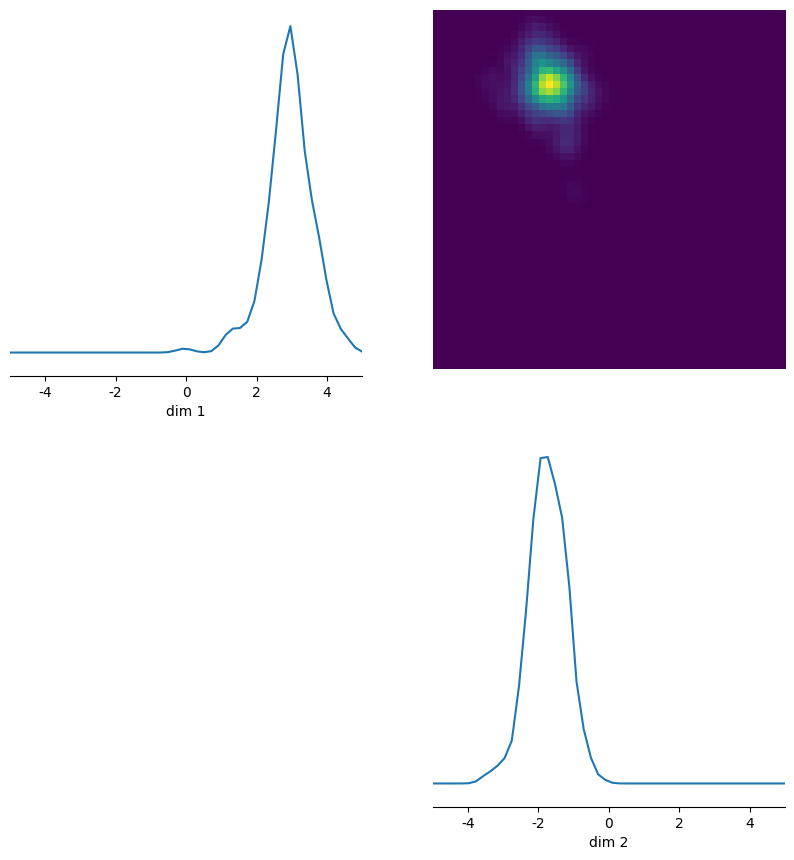

In [ ]:
log_probability = posterior.log_prob(samples, x=observation[0])
out = analysis.pairplot(samples, limits=[[-5,5],[-5,5]], fig_size=(6,6), upper='kde', diag='kde')


In [ ]:
observation[0]

tensor([ 3.1898, -1.4199])

In [ ]:
def log_prob(theta, x):
    lp =  - 0.5* ((x[0]-theta[0])**2 + (x[1]-theta[1])**2)/(0.5**2)
    return lp.numpy()

In [ ]:

samples[0].numpy()

array([ 2.4309418, -2.4132135], dtype=float32)

In [ ]:

import emcee

In [ ]:


# def log_prob(x, ivar):
#     return -0.5 * np.sum(ivar * x ** 2)

ndim, nwalkers = 2, 10
# ivar = 1. / np.random.rand(ndim)
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[observation[1]])
state = sampler.run_mcmc(p0, 100)
sampler.reset()
state = sampler.run_mcmc(state, 5000)
samples2 = sampler.get_chain(flat=True)

In [ ]:
samples.shape

torch.Size([200, 2])

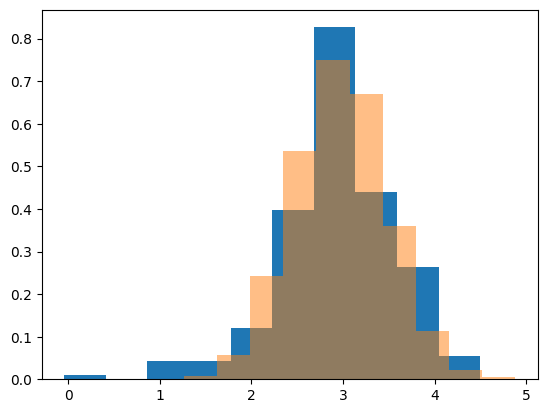

(array([0.00170114, 0.02271528, 0.12813617, 0.45415541, 0.75936066,
        0.66344616, 0.34933492, 0.10391988, 0.01571057, 0.00320215]),
 array([-3.66885296, -3.26912195, -2.86939095, -2.46965994, -2.06992894,
        -1.67019793, -1.27046692, -0.87073592, -0.47100491, -0.07127391,
         0.3284571 ]),
 <BarContainer object of 10 artists>)

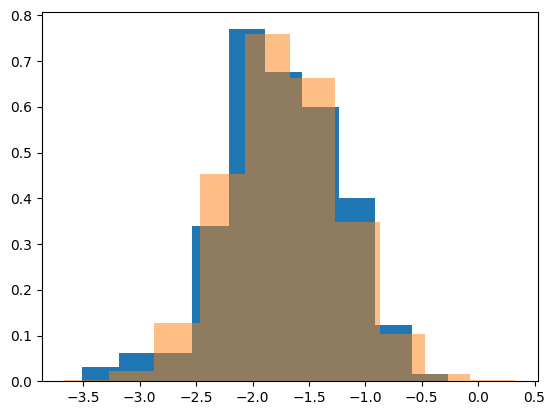

In [ ]:
i = 0
plt.hist(samples[:, i], density=True)
plt.hist(samples2[:, i], density=True, alpha=0.5)
plt.show()
i = 1
plt.hist(samples[:, i], density=True)
plt.hist(samples2[:, i], density=True, alpha=0.5)

# Power spectrum

In [ ]:
!pip install classylss

  Using cached classylss-0.2.9.tar.gz (244 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!conda version

/bin/bash: line 1: conda: command not found
